In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import rgb_to_grayscale

import os
import matplotlib.pyplot as plt
AUTO = tf.data.AUTOTUNE

In [10]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2025-02-08 18:10:29.312147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2446 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-02-08 18:10:29.312643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22214 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [41]:
base_dir = '../ML Research/ILSVRC/Data/CLS-LOC'
train_dir = os.path.join(base_dir, 'train/')
val_dir = os.path.join(base_dir, 'val/')
test_dir = os.path.join(base_dir, 'test/')

In [56]:
def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.resize(image, (160, 160))

    grayscale = rgb_to_grayscale(image)
    
    # grayscale = (grayscale / 127.5) - 1
    # image = (image / 127.5) - 1

    return grayscale, image

In [57]:
def get_dataset(path, batch_size=32):
    image_paths = tf.data.Dataset.list_files(path + "*.JPEG", shuffle=True)
    dataset = image_paths.map(process_image, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size).prefetch(AUTO)
    return dataset

In [58]:
test_dataset = get_dataset(test_dir, batch_size= 128 * strategy.num_replicas_in_sync)

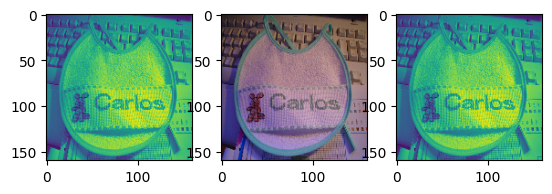

In [64]:
for batch in test_dataset.as_numpy_iterator():
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(batch[0][0] / 255)
    axs[1].imshow(batch[1][0] / 255)
    axs[2].imshow(rgb_to_grayscale(batch[1][0]) / 255)
    # print(batch[0][0])
    # print(batch[1][0])
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


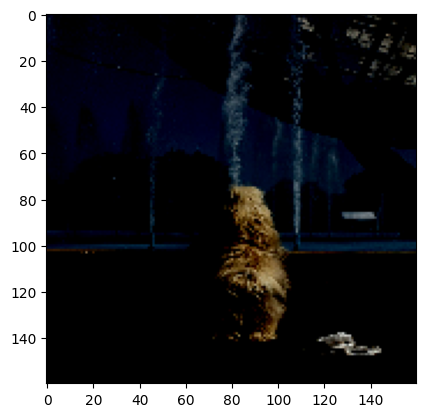

In [49]:
for batch in test_dataset.as_numpy_iterator():
    plt.imshow(batch[1][0])
    break

In [36]:
os.listdir(test_dir)[:5]

['ILSVRC2012_test_00022959.JPEG',
 'ILSVRC2012_test_00071972.JPEG',
 'ILSVRC2012_test_00000824.JPEG',
 'ILSVRC2012_test_00045324.JPEG',
 'ILSVRC2012_test_00081438.JPEG']

In [6]:
def convert_to_grayscale(image):
    return rgb_to_grayscale(image)

In [21]:
train_datagen = ImageDataGenerator(validation_split=0.05, preprocessing_function=convert_to_grayscale)
test_datagen = ImageDataGenerator(preprocessing_function=convert_to_grayscale)
non_grayscale_datagen = ImageDataGenerator()

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=128 * strategy.num_replicas_in_sync,
    class_mode='categorical',
    subset='training'
)

In [ ]:
val_data = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(160, 160),
    batch_size=128 * strategy.num_replicas_in_sync,
    class_mode='categorical',
    subset='validation'
)

In [65]:
test_data = test_datagen.flow_from_directory(
    val_dir,
    target_size=(160, 160, 1),
    batch_size=128 * strategy.num_replicas_in_sync,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 50000 images belonging to 1000 classes.


In [22]:
ngtest_data = non_grayscale_datagen.flow_from_directory(
    val_dir,
    target_size=(160, 160),
    batch_size=128 * strategy.num_replicas_in_sync,
    class_mode='categorical'
)

Found 50000 images belonging to 1000 classes.


In [66]:
batch = next(test_data)

InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Matrix size-incompatible: In[0]: [25600,1], In[1]: [3,1] [Op:MatMul] name: 

(160, 160, 3)


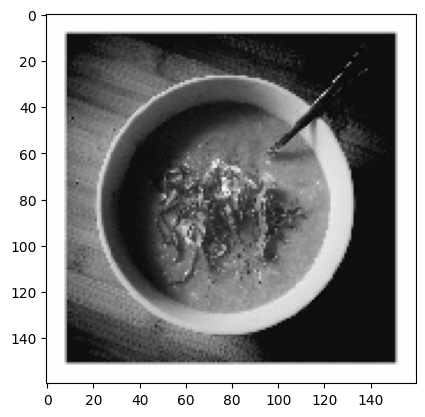

In [28]:
plt.imshow(batch[0][0] / 255)
print(batch[0][0].shape)

In [23]:
ng_batch = next(ngtest_data)

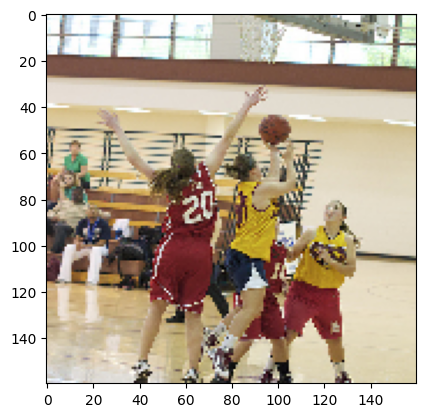

In [27]:
plt.imshow(ng_batch[0][5] / 255)

In [33]:
print(ng_batch[0][5].shape)
rgb_to_grayscale(ng_batch[0][5])

(160, 160, 3)


<tf.Tensor: shape=(160, 160, 1), dtype=float32, numpy=
array([[[245.8551 ],
        [252.26291],
        [252.70361],
        ...,
        [195.241  ],
        [180.8034 ],
        [168.8568 ]],

       [[252.1812 ],
        [254.1056 ],
        [254.4476 ],
        ...,
        [245.9492 ],
        [248.0908 ],
        [249.3295 ]],

       [[230.2911 ],
        [236.69261],
        [248.9149 ],
        ...,
        [239.779  ],
        [245.3253 ],
        [243.7247 ]],

       ...,

       [[205.6697 ],
        [196.1608 ],
        [195.8681 ],
        ...,
        [209.8639 ],
        [208.864  ],
        [209.8639 ]],

       [[246.87201],
        [247.6485 ],
        [238.08391],
        ...,
        [205.15251],
        [206.97821],
        [206.97821]],

       [[217.82109],
        [208.69101],
        [207.8913 ],
        ...,
        [206.97821],
        [206.86421],
        [207.9781 ]]], dtype=float32)>